# Introduction to Regularization for Deep Neural Nets

## Stephen Elston
## Machine Learning 410

This lesson will introduce you to the principles of regularization required to successfully train deep neural networks. In this lesson you will:

1. Understand the need for regularization of complex machine learning models, particularly deep NNs. 
2. Know how to apply constraint-based regularization using the L1 and L2 norms.
3. Understand and apply the concept of data augmentation. 
4. Know how to apply dropout regularization. 
5. Understand and apply early stopping. 
6. Understand the advantages of various regularization methods and know when how to apply them in combination. 


**Required readings** from GBC for this lesson:
1. 7.0
2. 7.1 
3. 7.2
4. 7.3
5. 7.4
6. 7.5
7. 7.8
8. 7.11
9. 7.12


****
**Note:** To run notebook you must have Keras package installed, In addition you will need the `hdf5` package installed. You can install this package using either anaconda or pip from a command prompt, as follows:

`conda install hdf5`

Or,

`pip install hdf5`
****

## 1.0 Why do we need regularization for deep learning?

Deep learning models have a great many parameters (weights) which must be fit. This situation arises from the wide and deep architectures that are required to achieve significant **model capacity** for representing complex functions. The core issue is that over-fit models will simply learn the training data and **over-fit models do not generalize**. Therefore, regularization methods are required in order to prevent over-fitting.

In particular, we can point to three interrelated problems with training deep neural networks:

1. Neural network models have large numbers of parameters (weights). With any finite size data set, there is likely to be a low ratio of cases per parameter or low ratio of cases to features. For example, if we are classifying 512 x 512 images with 1,000,000 training cases there are only about 4 cases per feature. This is why training neural networks often requires massive amounts of data. 
2. As a result of the large numbers of parameters, neural networks are susceptible to noise in the training data. Neural networks are generally considered less robust to noise than shallow machine learning methods. 
3. Presumably as a result of the model complexity, neural networks often return unexpected predictions for data cases outside the training data domain. This property has been referred to as **brittleness**. Brittleness has proven to be serious problem in some production systems. 

The regularization methods presented here will limit these effects. However, there is no 'silver bullet'! Neural networks are hard to train under the best of circumstances. 

### 1.1 Bias-variance trade-off

When applying regularization one must come to terms with the **bias-variance trade-off**. Here are some simple examples of extreme cases:

- If we say that our prediction for all cases is just the mean (or median), we have minimized the variance. The estimate for all cases is the same, so the bias of the estimates is zero. However, there is likely considerable variance in these estimates. 
- On the other hand, we can fit the same data with a kNN model with k=1. The training data will fit this model perfectly, since there  is one model coefficient per training data point. The variance will be low. On the other had the model will have considerable bias when applied to test data. 

In either case, these extreme models will not generalize well and will exhibit large errors on any independent test data. Any practical model must come to terms with the trade-off between bias and variance to make accurate predictions. 

To better understand this trade-off let's decompose mean square error for a model as follows:

$$\Delta x = E \big[ Y - \hat{f}(X) \big]$$

Where,
$Y = $ the label vector.  
$X = $ the feature matrix.   
$\hat{f}(x) = $ the trained model.   

Expanding this relation gives us:

$$\Delta x = \big( E[ \hat{f}(X)] - \hat{f}(X) \big)^2 + E \big[ ( \hat{f}(X) - E[ \hat{f}(X)])^2 \big] + \sigma^2\\
\Delta x = Bias^2 + Variance + Irreducible\ Error$$



Regularization will reduce variance, but increase bias. Regularization parameters must be chosen to minimize minimize $\Delta x$. In many cases, this will prove challenging. 

Notice that the **irreducible error** is the limit of model accuracy. Even if we had a perfect model with no bias or variance, the irreducible error is inherent in the data and problem. 

### 1.2 Demonstration of over-parameterization

Let's try a simple example. We will construct a regression models with different numbers of parameters and therefore different model capacities. 

As a first step, we will create a simple single regression model of some synthetic data. The code in the cell below creates data computed from as a straight line, but with considerable Normally distributed random noise. A plot is then created of the result. Execute this code and examine the resulting plot.  

Using TensorFlow backend.


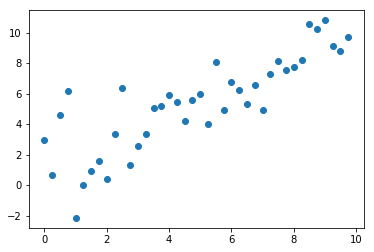

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
from numpy.random import normal, seed
import sklearn.linear_model as slm
from sklearn.preprocessing import scale
import sklearn.model_selection as ms
from math import sqrt
import keras
import keras.models as models
import keras.layers as layers
from keras.layers import Dropout, LeakyReLU
from keras import regularizers
from keras.layers.normalization import BatchNormalization

seed(34567)
x = np.arange(start = 0.0, stop = 10.0, step = 0.25) 
y = np.add(x, normal(scale = 2.0, size = x.shape[0]))

plt.scatter(x,y)

Notice that thees data points fall approximately on a straight line, but with significant deviations. 

Next, we will compute a simple single regression model. This model has an intercept term and a single slope parameter. The code in the cell below splits the data into randomly selected training and testing subsets. Execute this code.

In [2]:
indx = range(len(x))
seed(9988)
indx = ms.train_test_split(indx, test_size = 20)
x_train = np.ravel(x[indx[0]])
y_train = np.ravel(y[indx[0]])
x_test = np.ravel(x[indx[1]])
y_test = np.ravel(y[indx[1]])

Next, we will use the linear model in `sklearn.linear_model` package to create a single regression model for these data. The code in the cell below does just this, prints the single model coefficient, and plots the result. Execute this code. 

***
**Note:** you can find documentation along with some examples of scikit-learn regression models on the [regression models pages](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
***

[2.18028763]


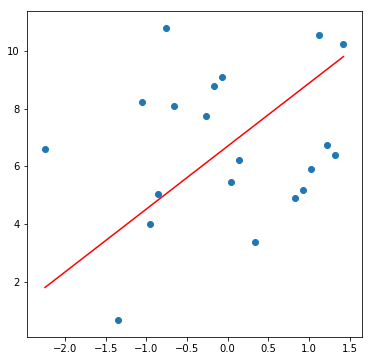

In [3]:
def plot_reg(x, y_score, y):
    ax = plt.figure(figsize=(6, 6)).gca() # define axis
    
    ## Get the data in plot order
    xy = sorted(zip(x,y_score))
    x = [x for x, _ in xy]
    y_score = [y for _, y in xy]

    ## Plot the result
    plt.plot(x, y_score, c = 'red')
    plt.scatter(x, y)

def reg_model(x, y):
    mod = slm.LinearRegression()
    x_scale = scale(x)  # .reshape(-1, 1)
    mod.fit(x_scale, y)
    print(mod.coef_)
    return mod, x_scale, mod.predict(x_scale)

mod, x_scale, y_hat = reg_model(x_train.reshape(-1, 1), y_train)

plot_reg(x_scale, y_hat, y_train)

Examine these results. Notice that the single coefficient (slope) seems reasonable, given the standardization of the training data. Visually, the fit to the training data also looks reasonable. 

We should also test the fit to some test data. The code in the cell does just this and returns the RMS error. execute this code.

1.9292639905624638

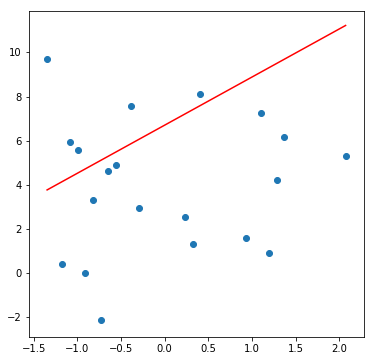

In [4]:
from math import sqrt
def test_mod(x,y, mod):
    x_scale = scale(x)
    y_score = mod.predict(x_scale)
    plot_reg(x_scale, y_score, y)
    return np.std(y_score - y)

test_mod(x_test.reshape(-1, 1), y_test, mod)

Again, these results look reasonable. The RMSE is relatively small given the significant dispersion in these data. 

Now, let's try a model with significantly higher capacity. In this case we compute new features for a 9th order polynomial model. Using this new set of features a regression model is trained and a summary displayed. 

[    3801.79377101   -55910.91605895   340393.61244177 -1135034.00389994
  2291726.97962741 -2884767.48230414  2217807.98144177  -954167.45864495
   176179.90377912]
0.7329681695593488


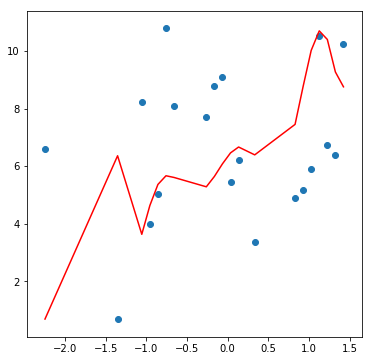

In [5]:
seed(2233)
x_power = np.power(x_train.reshape(-1, 1), range(1,10))
x_scale = scale(x_power)

mod_power = slm.LinearRegression()
mod_power.fit(x_scale, y_train)
y_hat_power = mod_power.predict(x_scale)

plot_reg(x_scale[:,0], y_hat_power, y_train)

print(mod_power.coef_)
print(np.std(y_hat_power - y_train))

Notice the following, indicating the the model is quite over-fit. 
- There is a wide range of coefficient values across 7 orders of magnitude. This situation is in contrast to the coefficient of the single regression model which had a reasonable single digit value.
- The graph of the fitted model shows highly complex behavior. In reality, this behavior indicates the model is 'learning the data'.  

Now, we will try to test the model with the held-back test data. The code in the cell below creates the same features and applies the `predict` method to the model using these test features. 

1005937.9130351634


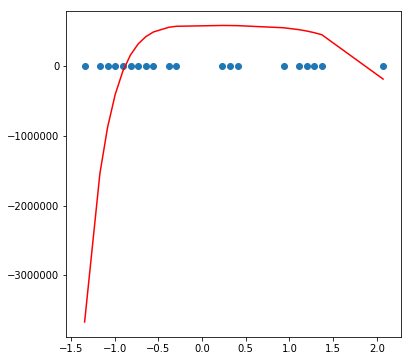

In [6]:
x_test_scale = scale(x_test.reshape(-1, 1)) # Prescale to prevent numerical overflow. 
x_test_power = np.power(x_test_scale, range(1,10))
x_scale_test = scale(x_test_power)

y_hat_power = mod_power.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_power, y_test)

print(np.std(y_hat_power - y_test))

This is clearly a terrible fit! The RMSE is enormous and the curve of predicted values bears little resemblance to the test values. Indeed, this is a common problem with over-fit models that the errors grow in very rapidly toward the edges of the training data domain. We can definitely state that this model **does not generalize**. 

## 2.0 l2 regularization

We will now explore one of the mostly widely used regularization methods, often referred to as l2 regularization. 

The same method goes by some other names, as it has been 'invented' several times. In particular this method is known as, **Tikhonov regularization**, **l2 norm regularization**, **pre-whitening** in engineering, and for linear models **ridge regression**. In all likelihood the method was first developed by the Russian mathematician Andrey Tikhonov in the late 1940's. His work was not widely known in the West since his short book on the subject, [Solution of Ill-Posed Problems](https://www.researchgate.net/publication/44438630_Solutions_of_ill-posed_problems_Andrey_N_Tikhonov_and_Vasiliy_Y_Arsenin), was only published in English in 1977, about 30 years after it had appeared in Russian.

![](img/Tikhonov_board.jpg)
<center> **Figure 2.1   
Commemorative plaque for Andrey Nikolayevich Tikhonov at Moscow State University**


So, what is the basic idea? l2 regularization applies a **penalty** proportional to the **l2** or **Euclidean norm** of the model weights to the loss function. The total loss function then becomes:  

$$J(W) = J_{MLE}(W) + \lambda ||W||^2$$

Where,

$$||W||^2 = \big( w_1^2 + w_2^2 + \ldots + w_n^2 \big)^{\frac{1}{2}} = \Big( \sum_{i=1}^n w_i^2 \Big)^{\frac{1}{2}}$$

We call $||W||^2$ the l2 norm of the weights since we square the power of the weights, sum, and then take the square root, or $\frac{1}{2}$ power. 

You can think of this penalty as constraining the 12 or Euclidean norm of the model weight vector. The value of the hyperparameter $\lambda$ determines how much the norm of the coefficient vector constrains the solution. You can see a view of this geometric interpretation in Figure 2.2 below.  

![](img/L2.jpg)
<center> **Figure 2.2. Geometric view of l2 regularization**

Notice that for a constant value of l2, the values of the model parameters $B1$ and $B2$ are related. For example, if $B1$ is maximized then $B2 \sim 0$, or vice versa. It is important to note that l2 regularization is a **soft constraint**. Coefficients are driven close to, but likely not exactly to, zero.   

****
**What is the difference between the L2 norm and l2 norm?**  Notice that we are discussing the l2 norm with a lower case 'l'. You will often find discussion of the L2 norm with an upper case 'L', or where the l2 and L2 notation are used interchangeably. In practice the difference can be subtle and is often ignored. 

We have already defined the l2 norm as the square root of the sum of the squares of a discrete variable (e.g. a set of weight values). Strictly speaking the L2 norm is the equivalent metric for a continuous function. For example, we can write express the L2 norm of a continuous function $\phi(x)$ as: 

$$||\phi(x)||^2 = \langle \phi(x), \phi(x) \rangle = \int \phi(x)^2 dx$$
****

### 2.1 The eigenvalue penalty interpretation

To develop deeper understanding of l2 regularization we look at the eigenvalue-eigenvector decomposition for a linear model. While neural networks are clearly nonlinear, the behavior is approximately linear locally, particularly near a minimum of the loss function.    

Let's start by examining the **normal equation** formulation of the linear regression problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ and a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

The commonly used normal equation form can help with this problem:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is a symmetric $m x m$ covariance matrix, where $m$ is the number of model coefficients. This is a significant reduction in size when compared to $A$. 

Now, we can perform eigenvalue-eigenvector decomposition of $A^TA$:

$$A^TA = Q \Lambda Q^{-1}$$

Where,
$Q = $ unitary matrix of orthonormal **eigenvectors**, and
$\Lambda =$ diagonal matrix of **eigenvalues**. 

Since Q is unitary (unit norm), the inverse of $A^TA$ is easily computed:

$$(A^TA)^{-1} = Q \Lambda^{-1} Q^{-1}$$

Where,
$$\Lambda^{-1} = 
\begin{bmatrix}
    \frac{1}{\lambda_1}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_m}
\end{bmatrix}$$
and $\lambda_i$ is the ith eigenvalue. 

But, **$A^TA$ can still be rank deficient!** By rank deficient we mean that there are fewer non-zero eigenvalues of $A^TA$ than the dimension, $m$. Even is the ith eigenvalue is close to zero, $\frac{1}{\lambda_i}$ becomes very large and destabilizes the inverse. 

The basic idea of $l_2$ or ridge regression is to stabilize the inverse eigenvalue matrix,$\Lambda$, by **adding a small bias term**, $\alpha$, to each of the eigenvalues. We can write this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \alpha^2 \cdot b\parallel]\\  or \\
b = (A^TA + \alpha^2 \cdot I)^{-1}A^Tx$$

In this way, the inverse values of small eigenvalues do not blow up when we compute the inverse. You can see this by writing out the $\Lambda^+$ matrix with the bias term.

$$\Lambda_{ridge}^+  = \begin{bmatrix}
    \frac{1}{d_1 + \alpha^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{d_2 + \alpha^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{d_m + \alpha^2}
\end{bmatrix}$$

Adding this bias term ensures there are no non-zero eigenvalues, and that the inverse of $A^TA$ exists. You can also see that added the bias term adds a 'ridge' along the diagonal of the eigenvalue matrix, giving this method one of its names. 

### 2.2 The Bayesian Interpretation

Another way to view l2 regularization is using a Bayesian formulation of the problem. Let's start with the posterior distribution of the weight vector $W$ given the features $X$ and labels $Y$. Using Bayes rule we can write this posterior distribution as:

$$p( W\ |\ \{X,Y\} ) = \frac{p(W)\ p(\{X,Y\}\  |\  W\ )}{p( \{X,Y\})}$$

where,

$p(W) = $ the prior distribution of $W$.   
$p(\{X,Y\}\  |\  W\ ) = $ the likelihood of $\{X,Y\}$ given $W$.

We want the **maximum a posteriori** or **MAP** of the weights, $W$. Taking the log of both sides:

$$max_W log \big( p( W\ |\ \{X,Y\} ) \big) = max_W\ \Big[ log \big( p(W) \big)\  + log \big( p(\{X,Y\}\  |\  W\ ) \big) \Big]\\
= max_W \Big[ log\big(prior(W)\big) + log \big( likelihood(\{X,Y\}\  |\  W\ ) \big) \Big]$$

For a Gaussian process with l2 loss and l2 regularization we formulate the problem:

$$max_W log \big( p( W\ |\ \{X,Y\} ) \big) = max_W \Big[\frac{1}{n} \sum_{i=1}^n (f_W(x_i) - y_i)^2 + \lambda || W ||^2 \big) \Big]$$  

where,   
$\frac{1}{n} \sum_{i=1}^n (f_W(x_i) - y_i)^2 = $ the likelihood.    
$\lambda || W ||^2 = $ the prior acting as a regularization penalty. 


So how are we to interpret this prior? It is useful to view the prior as constraining the norm of the weight vector close to zero. In other words, we think of the weights as **shrinking** toward zero. Thus, the shrinkage process prevents the weights from reaching extreme values. 

### 2.3 Regularization for regression  

Let's go back to our regression example. Recall that the 9th order polynomial regression model was massively over-fit. Can l2 regularization help this situation? We can create a model applying regularization and find out. 

The code in the cell below using the `Ridge` model from `sklearn.linear_model`. The `Ridge` model has an argument `alpha` which corresponds to the regularization parameter, in the notation we have been using. Execute the code and examine the result. 

1.2240592438232802
[ 1.35924056  0.30472335  0.21513283  0.2553236   0.25085494  0.17711915
  0.04339031 -0.13528087 -0.34506222]


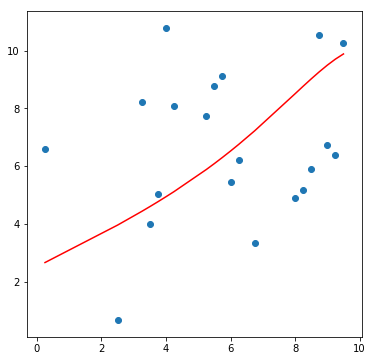

In [7]:
mod_L2 = slm.Ridge(alpha = 1.0)
mod_L2.fit(x_scale, y_train)
y_hat_L2 = mod_L2.predict(x_scale)

print(np.std(y_hat_L2 - y_train))
print(mod_L2.coef_)

plot_reg(x_train, y_hat_L2, y_train)

This model is quite different from the un-regularized one we trained previously. 
- The coefficients all have small values. Some of the coefficients are significantly less than 1. These small coefficients are a direct result of the l2 penalty.
- The fitted curve looks rather reasonable given the noisy data.

Let's test the model on the test data. Execute the code in the cell below and examine the results. 

1.9160891445046229


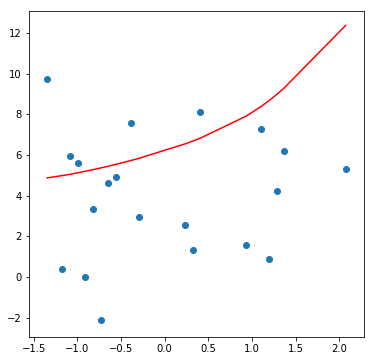

In [8]:
y_hat_L2 = mod_L2.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_L2, y_test)

print(np.std(y_hat_L2 - y_test))

This result looks a lot more reasonable. The RMSE is nearly the same as for the single feature regression example. Also, the predicted curve looks reasonable.

In summary, we have seen that l2 regularization significantly improves the result for the 9th order polynomial regression. The coefficients are kept within a reasonable range and the predictions are much more reasonable than the unconstrained model. 

### 2.4 l2 regularization for deep learning models 

So, you may well wonder, how well l2 regularization applies to neural networks? Let's give it a try using the 9th order polynomial data.  

The code in the cell below defines and fits regression model with a single hidden layer with 128 units. No regularization is applied in this first model. 

In [9]:
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                   verbose = 0)

With the model fit, let's have a look at the loss function vs. training epoch. Execute the code in the cell below and examine the result. 

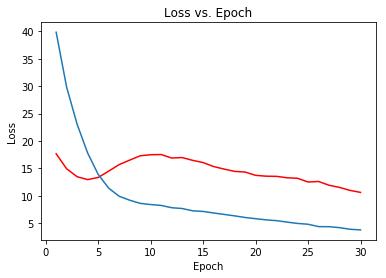

In [10]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red')
    plt.plot(x, train_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
plot_loss(history) 

It looks like this model becomes overfit after 3 or 4 training epochs. 

Execute the code in the cell below to compute and plot predictions for the unconstrained model. 

5.234739482473565


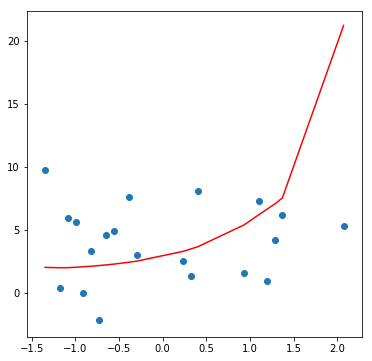

In [11]:
history = nn.fit(x_scale, y_train, 
                  epochs = 4, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                   verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

Both the high RMSE and the odd behavior of the predicted curve indicate that this model does not generalize well at all. Notice in particular, how the predicted curve moves away from the test data values on the right. 

Now, we will try to improve this result by applying l2 norm regularization to the neural network. The code in cell below adds l2 regularization to the model. Execute the code and examine the results.

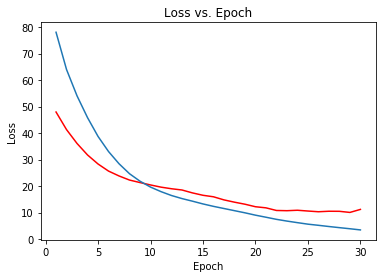

In [12]:
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(2.0)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
plot_loss(history)

This loss function is quite a bit different than for the unconstrained model. It is clear that regularization allows many more taining epochs before over-fitting. 

But are the predictions any better? Execute the code in the cell below and find out. 

3.4275788633381885


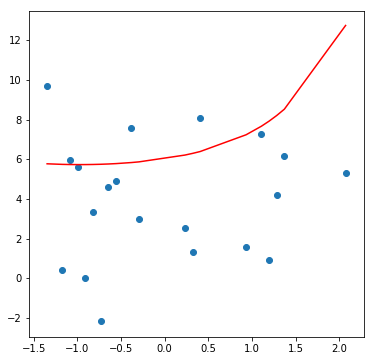

In [13]:
history = nn.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

The l2 regularization has reduced the RMSE. Just as significantly, the pathalogical behavior of the predicted values on the right is reduced, but clearly not eliminated. 

## 3.0 l1 regularization

We can also do regularization using other norms. The **l1 regularization** or **Lasso**  method limits the sum of the absolute values of the model coefficients. The l1 norm is sometime know as the **Manhattan norm**, since distance are measured as if you were traveling on a rectangular grid of streets. This is in contrast to the l2 norm that measures distance 'as the crow flies'. 

We can compute the l1 norm of the weights as follows:

$$||W||^1 = \big( |w_1| + |w_2| + \ldots + |w_n| \big) = \Big( \sum_{i=1}^n |w_i| \Big)^1$$

where $|x|$ is the absolute value of $x$. 

Notice that to compute the l1 norm, we raise the sum of the absolute values to the first power.

As with l2 regularization, in l1 regularization  we use a penalty term of the l1 norm of the weights. A penalty multiplier, $\alpha$, determines how much the norm of the coefficient vector constrains values of the weights. The complete loss function then becomes: 

$$J(W) = J_{MLE}(W) + \alpha ||W||^1$$

You can see a view of this geometric interpretation in Figure 3.1 below.  

![](img/L1.jpg)
<center> **Figure 3.1. Geometric view of L1 regularization**

Notice that in Figure 3.1 if $B1 = 0$ then $B2$ has a value at the limit, or vice versa. In other words, using a l1 norm constraint forces some weight values to zero to allow other coefficients to take correct values. In this way, the l1 norm constraint **knocks out** some weights from the model altogether. In contrast to l2 regularization, l1 regularization will drive some coefficients to exactly zero. 

### 3.1 l1 regularized regularization

With these ideas in mind, let's apply l1 norm regularization to the 9th order polynomial regression problem. The code in cell below applies l1 regularized or Lasso regularization to the linear regression problem. Execute this code and examine the results. 

3.0045160491799976
[1.85254516 0.         0.         0.12691421 0.01566206 0.
 0.         0.         0.        ]


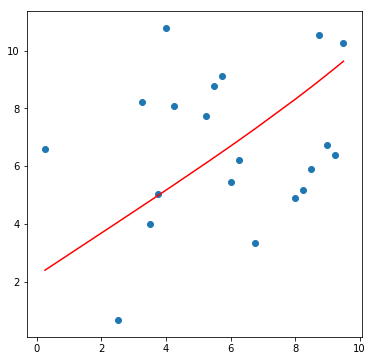

In [14]:
mod_L1 = slm.Lasso(alpha = 0.2, max_iter=100000)
mod_L1.fit(x_scale, y_train)
y_hat_L1 = mod_L1.predict(x_scale)

print(np.std(y_hat_L1 - y_test))
print(mod_L1.coef_)

plot_reg(x_train, y_hat_L1, y_train)

Notice the following about the results of this l1 regularized regression:
- Many of the coefficients are 0, as expected.
- The fitted curve looks reasonable. 

Now, execute the code in the cell below and examine the prediction results. 

1.9367128130723688


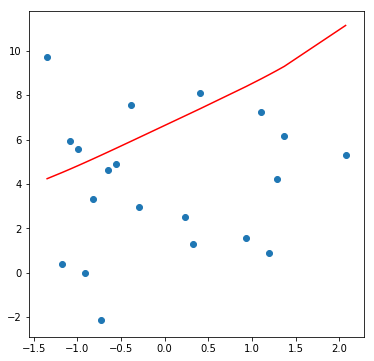

In [15]:
y_hat_L1 = mod_L1.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_L1, y_test)

print(np.std(y_hat_L1 - y_test))

The RMSE has been reduced considerably, and is less than for l2 regularization regression. The plot of predicted values looks similar to the single regression model, but with some bias. 


### 3.2 Neural network with l1 regularization

Now, we will try l1 regularization with a neural network. The code in the cell below defines, fits and plots a single layer neural network using l1 regularization. Execute this code and examine the results.

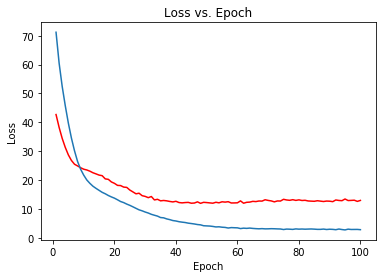

In [16]:
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l1(0.2)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
plot_loss(history)

As a result of the l1 regularization the training loss does not exhibit signs of over-fitting for quite a few epochs. 

Next, excute the code in the cell below to compute and display predicted values from the trained network. 

3.46488898580317


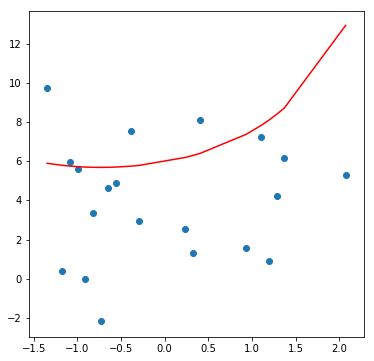

In [17]:
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

These results are a definite improvement. The RMSE is similar to that produced by the l2 regularization neural network. Further, the fitting curve shows similar behavior and bias. This bias is the result of the regularization. 

## 4.0 Early stopping

Early stopping is conceptually simple. Early stopping terminates the training of the neural network model at an epoch before it becomes terribly over-fit. That's it! That is the idea of early stopping.

In fact, we have already been using early stopping as we create and test the foregoing regularized models. The question here is, how do we automate this process? 

### 4.1 Early stopping algorithm

The early stopping algorithm simple. This pseudo code shows the basic loop for early stopping on first epoch with a lower performance metric, which is executed after the first training epoch of the model. 

`Do while TRUE:  
    store current model parameters   
    update model for epoch  
    if(performance_for_epoch < stored_performance_metric)  
        return stored_model  
    else  
        stored_performance_metric = performance_for_epoch   
        store_model = model  
`  



### 4.2 How does early stopping work?

Early stopping terminates model learning before over-fitting occurs. But how can we interpret this action in terms of the loss function $J(W)_{MLE}$? Figure 4.1 below provides some insight.   

![](Figures/EarlyStopping.JPG)
<center>**Figure 4.1 Effect of early stopping on $$J(W)_{MLE}$$**</center>

On the left side of the diagram you can see contours of the weight norm. On the right are contours  Early stopping terminates training at some model weight norm $||W||^2$. Ideally this is at the point where the training of $J(W)_{MLE}$ starts to over-fit. Thus, we can think of early stopping as analogous to l2 norm regularization where we write the loss function as:

$$argmin_W J(W) = J(W)_{MLE} + \alpha ||W||^2$$

where,

$\alpha = $ a regularization parameter controlling the stopping point. 

### 4.3 Early stopping example

Manually applying early stopping is both computationally inefficient and rather tedious. Fortunately, Keras has a build in capability that allows automation. 

To implement this early stopping we need to define 2 Keras **callbacks**. Two such callbacks are required:
1. The first callback, **EarlyStopping**, is for the early stopping method.
2. The second call back **checkpoints** or saves the current model. 

These callbacks are defined in the form of a **callbacks list**. 

Notice that the model defined includes l2 regularization. Thus, this model should replicate the performance observed with manual early stopping. To see how this works, examine and then execute the code in the following cell.

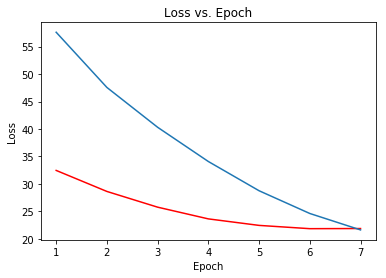

In [18]:
## First define and compile a model. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(1.0)))
nn.add(layers.Dense(1))

nn.compile(optimizer = 'RMSprop', loss = 'mse', metrics = ['mae'])

## Define the callback list
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 1 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now fit the model
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

You can see the behavior of the loss with training epoch is behaving as with l2 regularization alone. Notice that the training has been automatically terminated at the point the loss function is at its optimum. 

Let's also have a look that the accuracy vs. epoch. Execute the code in the cell below and examine the result. 

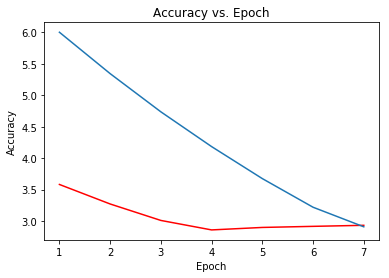

In [19]:
def plot_accuracy(history):
    train_acc = history.history['mean_absolute_error']
    test_acc = history.history['val_mean_absolute_error']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red')
    plt.plot(x, train_acc)  
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    
plot_accuracy(history)  

The curve of test accuracy is consistent with the test loss.

The code in the cell below retrieves the best model (by our stopping criteria) from storage, computes predictions and displays the result. Execute this code and examine the results. 

4.219468506744344


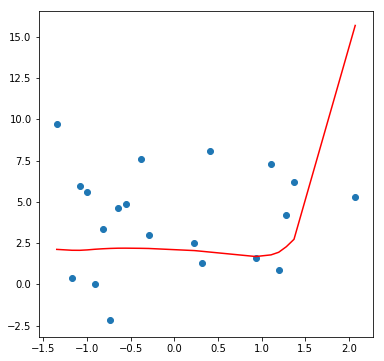

In [20]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

As expected, these results are similar, but a bit worse, than those obtained while manually stopping the training of the l2 regularized neural network.  

## 5.0 Dropout regularization

All of the regularization methods we have discussed so far, originated long before the current deep neural network era. We will now look at the **dropout regularization** method. Of all widely used regularization methods, dropout is the only one specifically developed for neural networks. The seminal paper, [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting by Srivastava et. al](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf), 2014, is quite readable and provides a lot more detail than is presented here.

We have already seen how l1 norm regularization knocks out some model weights. The **dropout method** method regularizes neural networks by creating an **ensemble** of networks with some fraction $p \lt 1.0$ of the hidden units removed. Ensemble methods are know to be strong regularizers and produce superior results by combining the learning of multiple **weak learners**. 

The dropout method is somewhat different from other ensemble methods, such as bagging. This reweighting scheme has several advantages:
- The model weights for the resulting network are reweighted by the probabilities they are sampled in the various networks of the ensemble. 
- The memory required to train the model is simply $O(n)$, where n is the number of weights. A bagged model requires  $O(M*n)$, where $M$ is the number of models in the ensemble.
- When making predictions in production only one model is used. Whereas, the predictions for each model in the bag must be computed for bagging. 

To understand this method, let's recall the basic model for a the output of a lth layer in a fully connected network:

$$z^{(l+1)}_i = w^{(l+1)}_i \cdot h^{(l)} + b^{(l+1)}_i\\
h^{(l+1)}_i = \sigma(z^{(l+1)}_i)$$

where:

$\sigma = $ the activation function. 

Now, we need to sample the hidden units with probability $p$, in which case we can write:

$$r^{(l)}_i \sim Bernoulli(p)\\
\tilde{h}^{(l)}_i = r^{(l)}_i * y^{(l)}\\
z^{(l+1)}_i = w^{(l+1)}_i \cdot \tilde{h}^{(l)}_i + b^{(l+1)}_i\\
h^{(l+1)}_i = \sigma(z^{(l+1)}_i)$$

where:

$r^{(l)}_i =$dropout vector with values $\{0,1\}$.

To get a feel for what this means in practice examine Figure 5.1. This figure shows a fully connected network with 4 hidden units and a dropout probability $p = 0.5$. 

![](Figures/DropoutExample.JPG)
![](Figures/DropoutExample2.JPG)

<center>**Figure 5.1   
Possible dropouts for a simple fully connected network with p = 0.5**</center>

Examine Figure 5.1 and notice the following:

- There are 6 ways to achieve dropout with exactly 1/2 the units as shown. 
- No units might dropout with probability $p^4$. 
- A single unit might drop out with probability $p^3 (1-p)$. 
- All units might drop out with probability $(1-p)^4$. This case is not admissible so should not be sampled. 

In fact there are $n^2$ possible dropout patterns for a hidden layer with n units. This scaling quickly leads to a problem. For any realistic size network, it is not possible fully sample all of the possibilities. Instead, we need to use some kind of approximation with a reasonable number of samples. 

Ideally, we want a model that gives us the posterior probability of $y$, the output, given $x$ the input which we can write $p(y\ |\ x)$. If we had infinite computing resources we could Monte Carlo sample this distribution for our neural network. This ideal reference neural network is known as **Bayesian network**. Clearly, for large scale networks it is not possible to compute this result.   

We have to settle for a sampled result. We reweight by the probability that a sample is created. Continuing with the notation we used before we can write:

$$p(y\ |\ x) \sim \sum_r p(r) p(y\ |\ x, r)$$

where,

$r = $ the Bernoulli sampled mask vector. 

Given enough samples the approximation above will converge to the desired probability distribution. However, in practice it has been found that the **geometric mean** of the ensemble converges faster. 

### 5.1 Computing a neural network with dropout regularization

With a bit of theory in mind, we will now apply dropout regularization to training a neural network. The code in the cell below defines a neural network with a dropout layer with $p =0.5$. The rest of this network is identical to other networks we have been working with. Execute this code and examine the result. 

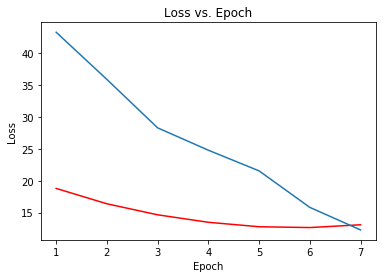

In [21]:
## First define and compile a model with a dropout layer. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(Dropout(0.5)) # Use 50% dropout on this model
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

## Now fit the model
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

The familiar loss plot looks a bit different here. Notice the kinks in the training loss curve. THis is likely a result of the dropout sampling. 

Execute the code in the cell below and examine the accuracy vs. epoch curves. 

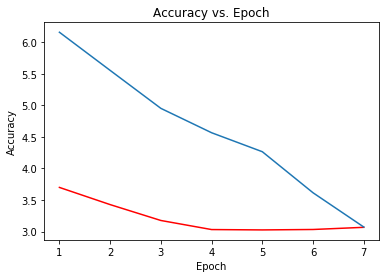

In [22]:
plot_accuracy(history)

The behavior of the training accuracy curve has a similar appearance to the loss curve in terms of the jagged appearance. 

Execute the code in the cell below examine the prediction results for this model. 

4.163060395230577


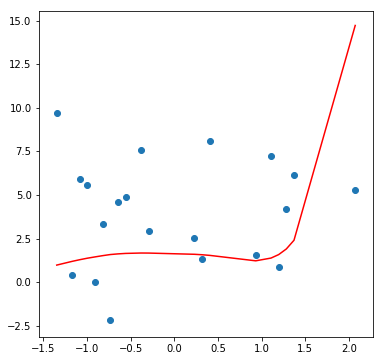

In [23]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

These results appear similar to those obtained with other regularization methods for neural networks on this problem. While the dropout method is an effective regularizer it is no 'silver bullet'. 

## 6.0 Batch Normalization

It is often the case that the distribution of output values of some hidden layers changes . The result is that propagated gradients can become near zero, significantly slowing convergence in many cases. We will discuss this **vanishing gradient problem** in another lesson.  

In 2015, [Sergey and Szegedy](https://arxiv.org/pdf/1502.03167.pdf) introduced a solution to this problem with their paper **Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift**. The basic idea is simple. A batch normalization layer maintains an exponential moving average estimate of the mean and variance of the outputs of learn. These values are used to normalize the output values of the preceding layer. In other words, the batch normalization layer ensures the distribution of the output values are constant. 

Let's try an example. The simple neural network model defined in the code cell below includes a batch normalization layer. Also notice that to improve convergence the early stopping has been modified to have a patience of 3. Execute this code.      

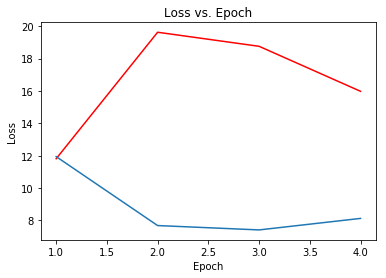

In [54]:
## Use patience of 3
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 3 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now, define an NN model using batch normalization. 
## First define and compile a model with a batch normalization layer. 
nn = models.Sequential()
#nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(layers.Dense(128, input_shape = (9, ), activation = 'relu'))
#nn.add(LeakyReLU(alpha=0.2))
#nn.add(Dropout(0.5)) # Use 50% dropout on this model
nn.add(BatchNormalization(momentum = 0.99))
nn.add(layers.Dense(128, activation = 'relu'))

#nn.add(LeakyReLU(alpha=0.2))
nn.add(layers.Dense(1))
## Define the optimizer and compile
optm = keras.optimizers.rmsprop(lr=1.0)
nn.compile(optimizer = optm, loss = 'mse', metrics = ['mae'])

## Now fit the model
history = nn.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

The loss decreases rapidly and then remains in a narrow range thereafter. It appears that convergence is quite rapid.

How does the accuracy evolve with the training episodes? Execute the code in the cell below to display the result.   

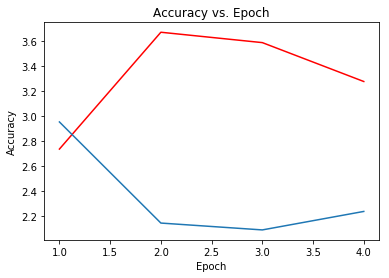

In [56]:
plot_accuracy(history)

This accuracy curve is rather unusual. It seems to reflect the simple regularization being used. 

Finally, execute the code in the cell below to evaluate the predictions made with this model. 

3.0109537582693684


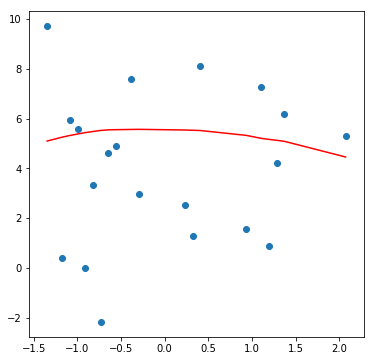

In [55]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

Despite the odd convergence properties of this model the fit to the test data is similar to that achieved with the  

## 7.0 Data augmentation and brittle neural networks

From the foregoing examples, you have likely noticed that the simple linear regression models give more satisfactory results than the neural network models. This is the case regardless of regularization method chosen, and is a demonstration of three interrelated and unfortunate properties of neural networks:

1. Neural network models have large numbers of parameters (weights). With any finite size data set, there is likely to be a low ratio of cases per parameter. 
2. As a result of the large numbers of parameters, neural networks are susceptible to noise in the training data.  
3. Presumably as a result of the model complexity, neural networks often return unexpected predictions for data cases far from the training data domain. This property has been referred to as **brittleness**. A corollary of this situation is that many deep neural networks are susceptible to **adversarial attacks**. In an adversarial attack, a set of input values outside the range of training cases can lead to unexpected, and sometimes damaging, results. 

One approach to reducing the brittleness of a neural network is to augment the training data. **Data augmentation** is a process of creating new training cases by adding small perturbations or noise to the original training cases. The desired result is a larger training data set which covers a larger domain of the possible space of features. 

### 7.1 Prewhitening as data augmentation

There are a number of ways to create augmented training data. We will explore other approaches elsewhere. Here, we will use a simple approach of adding **white noise** to existing training cases to create new cases. By white noise we mean broad spectrum noise, specifically Normally distributed noise.  

The idea of prewhitening has a long history in various disciplines, such as signal processing, image processing and control theory. The idea is simple. Normally distributed noise is added to the training data to create data cases with lower autocorrelation properties. 

To get a feel for how data augmentation using prewhitening acts as a regularizer, let's look at the simple case of linear regression. Skipping some tedious algebra we can formulate a white noise augmented linear regression problem. 

We can draw a array of independent identically distributed (iid) Normal random variables as follows:

$$G \sim Norm(\mu, \sigma) $$

We can compute the covariance of this vector random variable as follows:

$$Cov(G) = G^TG$$

Since $G$ is comprised of iid random variables, the off diagonal terms of the covariance matrix will be close to zero. Therefore, the covariance matrix is positive definite, and with no zero eigenvalues. This point is critical. If the augmentation method does not produce iid results, the model will have unwanted collinearities.  

If we have a matrix of features $X$ and labels $y$, we can create an augmented model matrix by concatenating a matrix $X + G$ onto the original $X$. The resulting model matrix has the same number of columns but with augmented rows. Since we have constructed $G$ to have a favorable covariance function out augmented model matrix will inherit some so this favorable characteristic.  

In the same way, we can augment the label vector to create a longer vector. Again, since the noise we are adding is iid, we expect a favorable covariance structure. Notice that we will need to make sure the order of the augmented features matches the order of the augmented labels. 

In effect, prewhitening stabilizes the eigenvalues of the covariance matrix. This process is similar to the ridge regression or l2 regularization. As with most other regularization methods, this process introduces bias. The magnitude of the white noise added determines the point on the bias-variance trade-off. 

### 7.2 Prewhitened neural network

Let's try a computational example. We will train a neural network using white noise augmented data. 

The code in the cell below performs the following steps:

1. A random resampling index is computed by Bernoulli sampling with replacement. 
2. Augment feature and label array are created by adding Normally distributed noise. 
3. The original data values are concatenated with the augmented values.
4. A plot is made to test the data augmentation.
5. The polynomial features are computed and scaled.

Execute this code and examine the results. 

(20,)
There are now 100 cases!


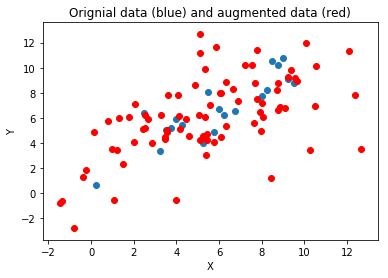

In [69]:
## Create an array of indicies to resample the the 
## original data with prepacement. 
nr.seed(3344)
size_mult = 4
noise = 2.0
n = x_train.shape[0]
indx = np.array(range(n))
indx = nr.choice(indx, size = size_mult*n )

## Create augmented data with small amount of noise
x_augment = np.add(x_train[indx], normal(scale = noise, size = size_mult*n))
y_augment = np.add(y_train[indx], normal(scale = noise, size = size_mult*n))

## Check the result
print(x_train.shape)
plt.scatter(x_train, y_train)
plt.scatter(x_augment, y_augment, color = 'red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Orignial data (blue) and augmented data (red)')

## Add in the original data cases and scale
x_augment = scale(np.concatenate((x_train, x_augment)))
y_augment = np.concatenate((y_train, y_augment))

## Compute the polynomial features
x_augment = np.power(x_augment.reshape(-1, 1), range(1,10))
x_augment = scale(x_augment)

print('There are now ' + str(x_augment.shape[0]) + ' cases!')

Visually, these data seem to have similar statistics to the original data. The augmentation has expanded the domain of the training data. Further, several of the data lie in tight clusters. 

Now, we are ready to compute the neural network model. The model uses both mild l2 and dropout regularization. 

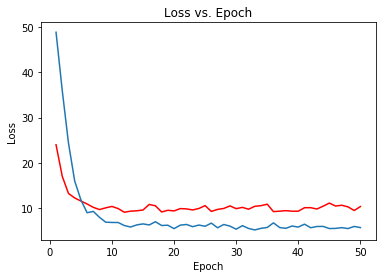

In [70]:
## First define and compile a model with a dropout layer. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(0.5)))
nn.add(Dropout(0.5)) # Use 50% dropout on this model
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

## Now fit the model
history = nn.fit(x_augment, y_augment, 
                  epochs = 50, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

Examine this plot and notice the point at which over-training appears to start. 

Let's plot the accuracy just to be sure. 

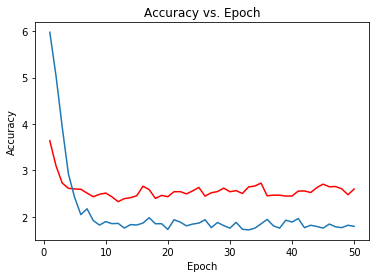

In [71]:
plot_accuracy(history)

The test accuracy curve has similar characteristics to the loss curve. 

Now, we will compute the predicted values and plot them. 

3.342889363900275


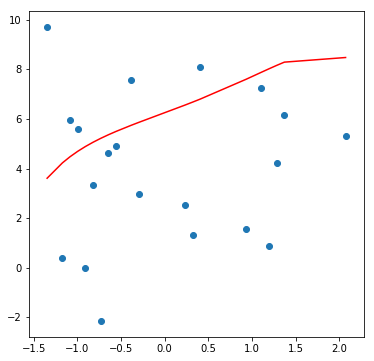

In [72]:
history = nn.fit(x_augment, y_augment, 
                  epochs = 8, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)

predictions = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

These results do not show the odd behavior of the other neural network models. There is still significant bias in the result. Apparently, the data augmentation is a strong regularizer. Still there is significant bias, so this is not the 'silver bullet' either. 

## 8.0 Using multiple regularization methods

In many cases more than one regularization method is applied. We have already applied early stopping with other regularization methods. In this demonstration we will use four regularization methods at once:
- l2 regularization.
- l1 regularization.
- Dropout.
- Early stopping. 

The code in the cell below defines and trains a single layer neural network applying all 4 methods. 

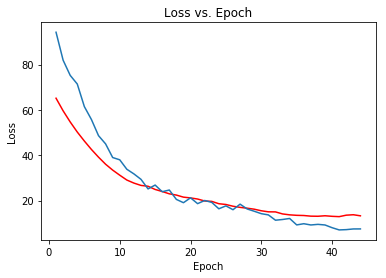

In [31]:
## First define and compile a model with a dropout layer. 
nn = models.Sequential()
## Dense layer with both l1 and l2 regularization
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l1_l2(0.4)))
nn.add(Dropout(0.5)) # Use 50% dropout
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

## Now fit the model
history = nn.fit(x_scale, y_train, 
                  epochs = 120, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

The loss vs epoch curve looks similar to others we have seen before. 

Compute the accuracy curve by executing the code below.

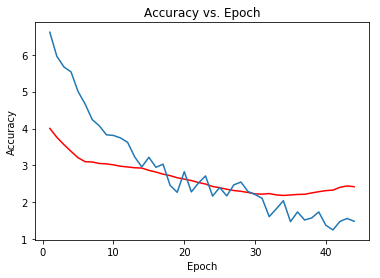

In [32]:
plot_accuracy(history)

Again, there are no surprises in the plot above. 

Finally, we can evaluate the predictions the model produces. Execute the code in the cell below and examine the result.

3.507097001429251


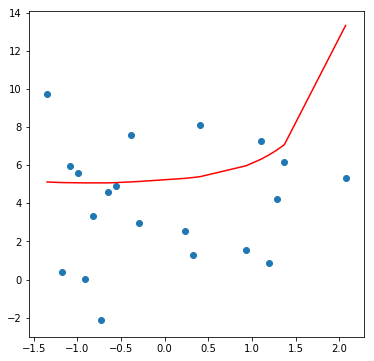

In [33]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

As you might expect the results are similar to others we have computed. Just to reiterate, there is no 'silver bullet' with regularization. On the other hand, without regularization neural networks would not produce useful results. 

#### Copyright 2018 Stephen F Elston. All rights reserved.